L2 norm of w: 12.795610427856445


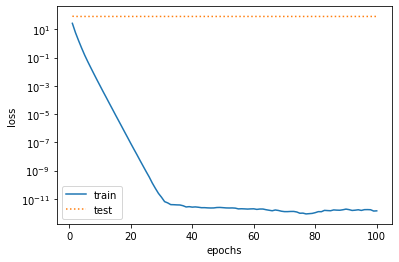

In [14]:
import torch
import torch.nn as nn 
import numpy as np 
import d2lzh as d2l
import matplotlib.pyplot as plt

n_train,n_test,num_inputs = 20,100,200
true_w,true_b = torch.ones(num_inputs,1) * 0.01,0.05

features = torch.randn((n_train + n_test,num_inputs))
labels = torch.matmul(features,true_w) + true_b 
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

train_features,test_features = features[:n_train,:],features[n_train:,:]
train_labels,test_labels = labels[:n_train],labels[n_train:]

def init_params():
    w = torch.randn((num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)

    return [w,b]

def l2_penalty(w):
    return (w**2).sum() / 2

def linreg(X,w,b):
    return torch.mm(X,w) + b 

def squared_loss(y_hat,y):
    return (y_hat - y.view(y_hat.size()))**2 / 2

batch_size = 1
num_epochs = 100
lr = 0.003

net = linreg
loss = squared_loss

dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)

def fit_and_plot(lam):
    w,b = init_params()
    train_ls,test_ls = [],[]

    for _ in range(num_epochs):
        for X,y in train_iter:

            l = loss(net(X,w,b),y) + lam * l2_penalty(w) # l2　惩罚项
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        
        train_ls.append(loss(net(train_features ,w,b),train_labels).mean().item())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().item())

    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),test_ls,['train','test'])

    print('L2 norm of w:',w.norm().item())

fit_and_plot(lam=0)

L2 norm of w: 0.02826516330242157


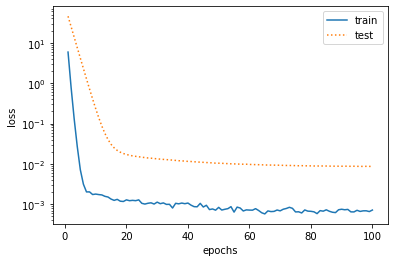

In [15]:
fit_and_plot(lam=5)

L2 norm of w: 13.88662338256836


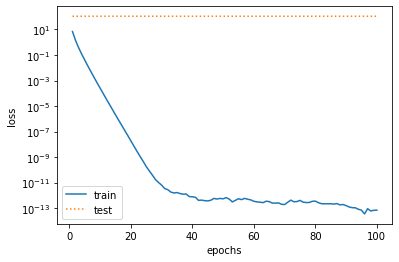

In [16]:
def fit_and_plot_pytorch(wd):

    net = nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.constant_(net.bias,val=0)

    optimizer_w = torch.optim.SGD(params=[net.weight],lr=lr,weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias],lr=lr) # 不使用衰减

    train_ls,test_ls = [],[]

    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_b.zero_grad()
            optimizer_w.zero_grad()

            l.backward()

            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())

    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),test_ls,['train','test'])

    print('L2 norm of w:',net.weight.data.norm().item())

fit_and_plot_pytorch(0)
        

L2 norm of w: 0.035129718482494354


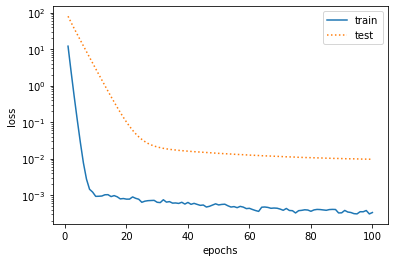

In [17]:
fit_and_plot_pytorch(3)

## 总结

- 正则化通过对模型损失函数添加惩罚项使学出的模型参数值较小，市应对过拟合的常用手段　
- 权重衰减等价于$L_2$范数，通常会使得学到的权重参数的值接近于０．　
- 可以定义多个优化器实现对不同模型参数使用不同的迭代方法。